In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def f(u, v):
    return u - u**3 / 3 - v


def g(u, v, a, b):
    return u + a - b * v


def laplacian_1d(f, dx):
    n = len(f)
    diagonal = -2 * np.ones(n)
    off_diagonal = np.ones(n - 1)
    laplacian = (
        np.diag(diagonal) + np.diag(off_diagonal, k=1) + np.diag(off_diagonal, k=-1)
    ) / dx**2

    # laplacian[-1, 0] = 1
    # laplacian[0, -1] = 1

    return laplacian @ f


# Simulation: regular FHN with selective saving
def simulate_regular_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=5, bc="periodic"
):
    x0, x1 = domain
    dx = (x1 - x0) / n_space
    t_vec_full = np.arange(0, T + dt, dt)
    t_space = int(T / dt)

    u = 0.1007 * np.zeros((n_space, t_space))
    v = 0.1003 * np.zeros((n_space, t_space))

    # Excite the center of the system
    u[:, 0] = -1.2720
    v[:, 0] = -0.5860
    mid = u[:, 0].size // 2
    mid_range = 30
    u[mid - mid_range : mid + mid_range, 0] = 0.8
    u[:, 0] = u[:, 0] + 0.01 * np.random.randn(n_space)
    # v[mid - mid_range : mid + mid_range, 0] = 0.1003

    # Generate x values
    x = np.linspace(-5, 5, n_space)

    for i in range(t_space - 1):
        uc = u[:, i]
        vc = v[:, i]

        lu = laplacian_1d(uc, dx)
        lv = laplacian_1d(vc, dx)

        u[:, i + 1] = uc + dt * (f(uc, vc) + Du * lu)
        v[:, i + 1] = vc + dt * (epsilon * g(uc, vc, a, b) + Dv * lv)

    return [np.linspace(x0, x1, n_space), t_vec_full[:-1], u, v]


# Simulation: mass-conserved FHN with selective saving
def simulate_mass_conserved_fhn(
    T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=1, bc="periodic"
):
    x0, x1 = domain
    dx = (x1 - x0) / n_space
    t_vec_full = np.arange(0, T + dt, dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u = 0.1 + 0.01 * np.random.randn(n_space, n_space)
    v = 0.1 + 0.01 * np.random.randn(n_space, n_space)
    u_list, v_list = [], []
    for idx, _ in enumerate(t_vec_full[1:], start=1):
        uf, vf = u.ravel(), v.ravel()
        u_ext = np.concatenate([uf, [0.0]])
        v_ext = np.concatenate([vf, [0.0]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult * uf) / (dx**2)
        Lv = (v_ext[nbrs].sum(axis=0) - mult * vf) / (dx**2)
        inner_u = f(u, v) + Du * Lu.reshape(n_space, n_space)
        inner_v = epsilon * g(u, v, a, b) + Dv * Lv.reshape(n_space, n_space)
        iu, iv = inner_u.ravel(), inner_v.ravel()
        iu_ext, iv_ext = np.concatenate([iu, [0.0]]), np.concatenate([iv, [0.0]])
        L2u = (iu_ext[nbrs].sum(axis=0) - mult * iu) / (dx**2)
        L2v = (iv_ext[nbrs].sum(axis=0) - mult * iv) / (dx**2)
        u = u - dt * L2u.reshape(n_space, n_space)
        v = v - dt * L2v.reshape(n_space, n_space)
        if idx % save_every == 0:
            u_list.append(u.copy())
            v_list.append(v.copy())
    t_sampled = t_vec_full[save_every::save_every]
    X = Y = np.linspace(x0, x1, n_space)
    return [X, Y, t_sampled[:-2], np.array(u_list), np.array(v_list)]

In [4]:
# Parameters
a = 0.1
b = 2
epsilon = 0.01
Du = 1.0
Dv = 1.0
n_space = 200

domain = (-175, 175)

# dx = 1.0
dx = (domain[1] - domain[0]) / n_space
dt_max = dx**4 / (8 * Du)
dt = min(0.01, dt_max * 0.5)

# Analysis & plotting
# Parameters
T = 200

# Simulations
xl, tl, uvc, vvc = simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)
# Xm, Ym, tm, um, vm = simulate_mass_conserved_fhn(
#     T, dt, n_space, domain, a, b, epsilon, Du, Dv, save_every=save_every
# )

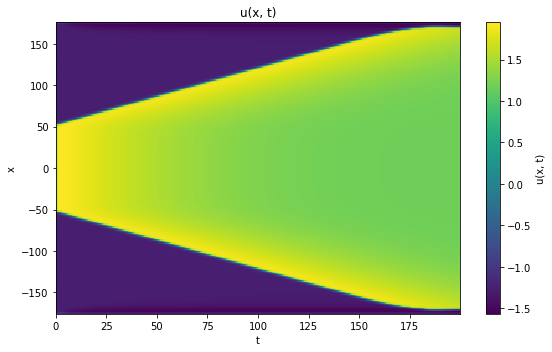

In [5]:
# Plotting
plt.figure(figsize=(8, 5))
plt.pcolormesh(tl, xl, uvc, shading="auto", cmap="viridis")
plt.colorbar(label="u(x, t)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("u(x, t)")
plt.tight_layout()
plt.show()

In [6]:
print(uvc[:, -1])

[-1.41205202 -1.56710699 -1.10631581  1.17798127  1.60151353  1.63560216
  1.61901655  1.5980531   1.57809529  1.55931967  1.54143167  1.52421926
  1.50756425  1.49140522  1.47571141  1.46046822  1.44566948  1.43131331
  1.41739991  1.40393031  1.39090568  1.37832693  1.36619462  1.35450878
  1.34326891  1.33247396  1.32212229  1.31221167  1.30273922  1.29370143
  1.28509405  1.27691213  1.2691499   1.26180083  1.25485751  1.24831172
  1.24215435  1.23637546  1.23096429  1.22590928  1.22119815  1.21681794
  1.21275513  1.20899569  1.20552521  1.20232902  1.19939226  1.19670005
  1.19423756  1.19199012  1.18994336  1.18808326  1.18639623  1.18486921
  1.18348969  1.18224576  1.18112617  1.1801203   1.1792182   1.17841059
  1.17768883  1.17704492  1.17647146  1.17596166  1.17550927  1.17510856
  1.17475432  1.17444176  1.17416655  1.17392476  1.17371279  1.17352742
  1.1733657   1.17322498  1.17310288  1.17299724  1.17290611  1.17282775
  1.1727606   1.17270325  1.17265446  1.1726131   1